# Testing reliability after HRF convolution

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(context='notebook',style='white')


ext_dir = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/UGTV_data_summary/'
int_dir = '/Users/catcamacho/Box/CCP/EmoCodes_project/reliability_data/analysis/'

In [11]:
def hrf(TR, duration, time_to_peak=6, undershoot_length=12):
    from scipy.stats import gamma
    
    time = np.arange(0, duration, TR)
    peak = gamma.pdf(time, time_to_peak)
    undershoot = gamma.pdf(time, undershoot_length)
    hrf_vals = peak-0.35*undershoot
    return(hrf_vals)

### AHKJ

In [24]:
out_dir = int_dir + 'AHKJ/hrf_analysis/'
extdata = pd.read_csv(ext_dir + 'AHKJ_ratings.csv', index_col=None)[['Positive','Negative']]

mm = MinMaxScaler((0,1))
extdata[['ext_pos_sc','ext_neg_sc']] = mm.fit_transform(extdata[['Positive','Negative']])

intdata = pd.read_csv(int_dir + 'AHKJ/internal_summary_scores.csv', index_col=None)[[ 'pos_ciaca_sc', 'neg_ciaca_sc','pos_cimca_sc', 'neg_cimca_sc']]
data = extdata[['ext_pos_sc','ext_neg_sc']].merge(intdata, left_index=True, right_index=True)
data.describe()

,ext_pos_sc,ext_neg_sc,pos_ciaca_sc,neg_ciaca_sc,pos_cimca_sc,neg_cimca_sc
count,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000
mean,0.218754,0.308202,0.134626,0.153484,0.190606,0.154498
std,0.218555,0.206025,0.150477,0.164608,0.211318,0.179122
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.072496,0.144422,0.000000,0.000000,0.000000,0.000000
50%,0.132679,0.260324,0.066667,0.127517,0.095238,0.100671
75%,0.275723,0.435428,0.248333,0.250000,0.334524,0.234899
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

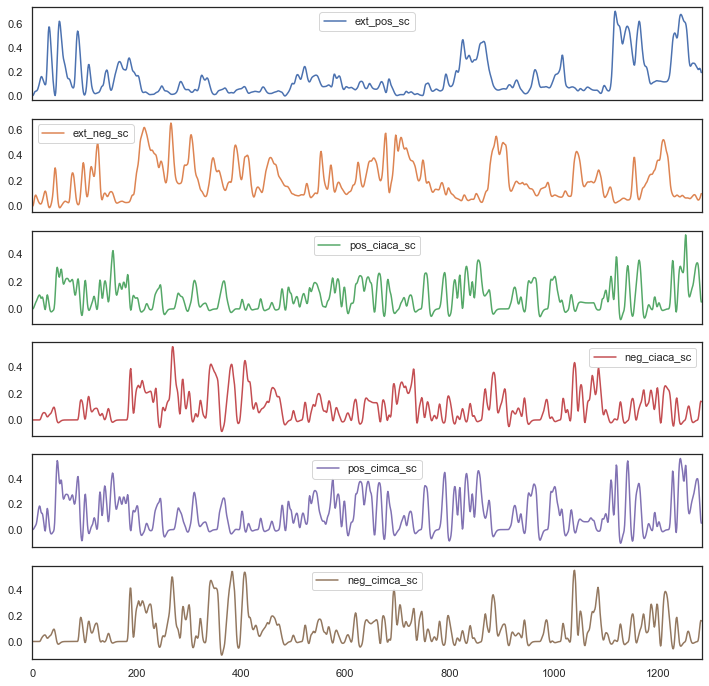

In [25]:
hrf_data = pd.DataFrame()

hrf_tr = hrf(1, len(data))
for a in data.columns:
    hrf_data.loc[:,a] = np.convolve(data[a], hrf_tr)[:len(data)]
    
hrf_data.plot(figsize=(12,12), subplots=True, xlim=(0, len(data)))

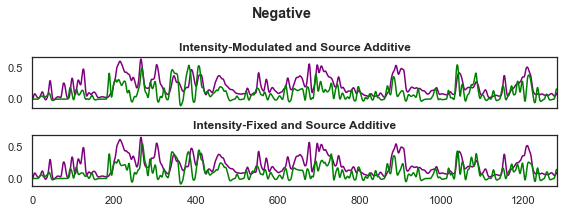

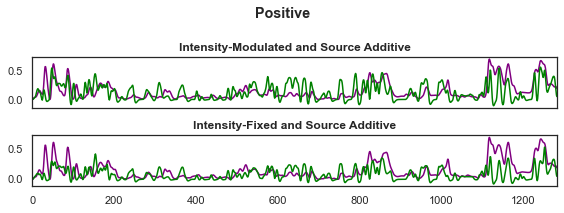

In [26]:
# plot negative
fig, ax = plt.subplots(2,1, figsize=(8,3), sharex=True)
fig.suptitle('Negative', weight='bold')
plt.setp(ax, xlim=(0,1284))
ax[0].plot(hrf_data['ext_neg_sc'], color='purple')
ax[0].plot(hrf_data['neg_cimca_sc'], color='green')
ax[0].set_title('Intensity-Modulated and Source Additive', weight='bold')
ax[1].plot(hrf_data['ext_neg_sc'], color='purple')
ax[1].plot(hrf_data['neg_ciaca_sc'], color='green')
ax[1].set_title('Intensity-Fixed and Source Additive', weight='bold')
plt.tight_layout()
plt.savefig(out_dir + 'internal-external_overlays_negative.svg')
plt.show()
plt.close()

# plot positive
fig, ax = plt.subplots(2,1, figsize=(8,3), sharex=True)
fig.suptitle('Positive', weight='bold')
plt.setp(ax, xlim=(0,1284))
ax[0].plot(hrf_data['ext_pos_sc'], color='purple')
ax[0].plot(hrf_data['pos_cimca_sc'], color='green')
ax[0].set_title('Intensity-Modulated and Source Additive', weight='bold')
ax[1].plot(hrf_data['ext_pos_sc'], color='purple')
ax[1].plot(hrf_data['pos_ciaca_sc'], color='green')
ax[1].set_title('Intensity-Fixed and Source Additive', weight='bold')
plt.tight_layout()
plt.savefig(out_dir + 'internal-external_overlays_positive.svg')
plt.show()
plt.close()

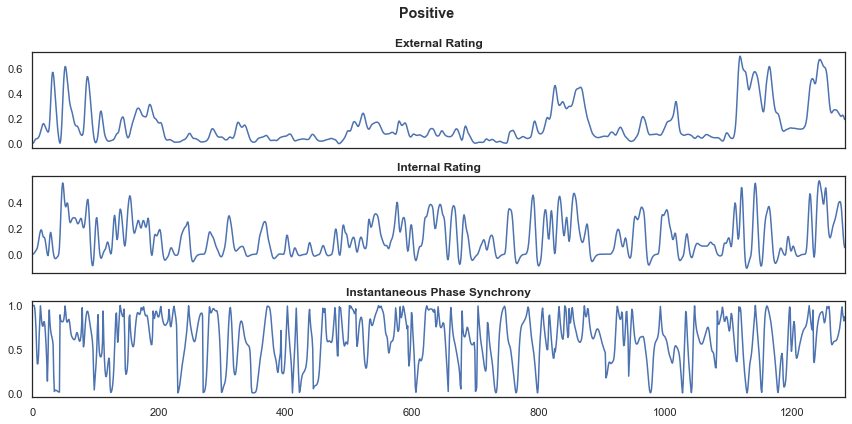

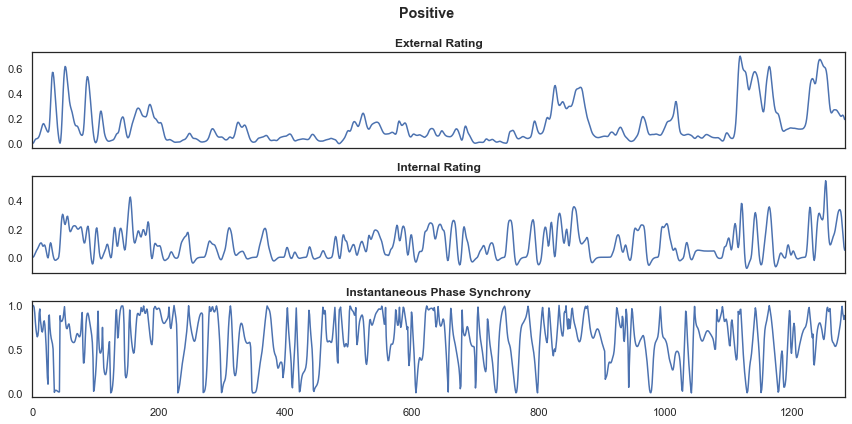

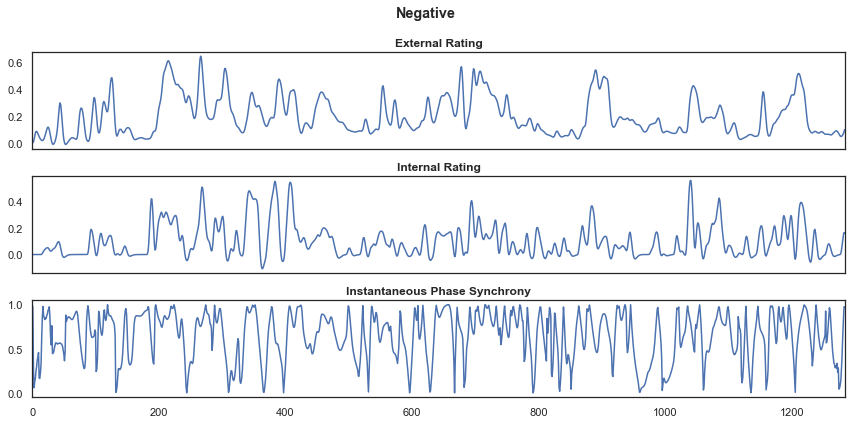

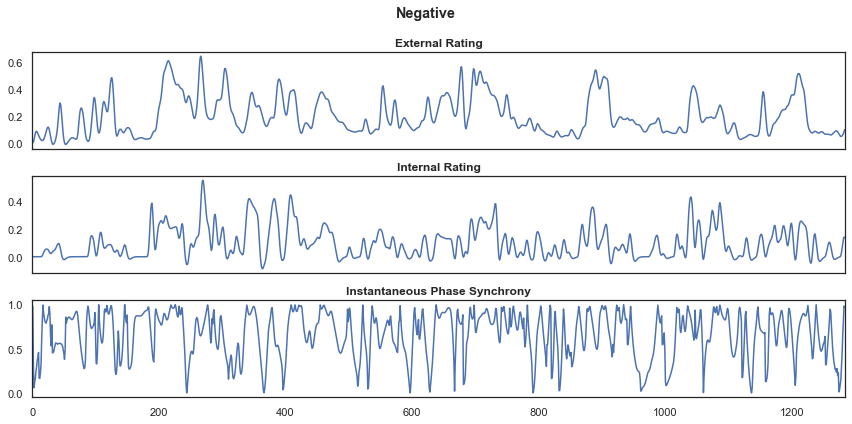

In [27]:
from scipy.signal import hilbert
from scipy.stats import spearmanr

# computer instantaneous phase synchrony
ips = pd.DataFrame(columns=['extpossc_meanIPS', 'extnegsc_meanIPS'])

for a in ['pos_cimca_sc','pos_ciaca_sc']:
    aphase = np.angle(hilbert(hrf_data['ext_pos_sc']),deg=False)
    bphase = np.angle(hilbert(hrf_data[a]),deg=False)
    phase_synchrony = 1-np.sin(np.abs(aphase-bphase)/2)
    ips.loc[a,'extpossc_meanIPS'] = np.mean(phase_synchrony)
    fig, ax = plt.subplots(3,1, figsize=(12,6), sharex=True)
    fig.suptitle('Positive', weight='bold')
    plt.setp(ax, xlim=(0,1284))
    ax[0].plot(hrf_data['ext_pos_sc'])
    ax[0].set_title('External Rating', weight='bold')
    ax[1].plot(hrf_data[a])
    ax[1].set_title('Internal Rating', weight='bold')
    ax[2].plot(phase_synchrony)
    ax[2].set_title('Instantaneous Phase Synchrony', weight='bold')
    plt.tight_layout()
    plt.savefig(out_dir + 'IPS_Negative_ext_{0}.svg'.format(a))
    plt.show()

for a in ['neg_cimca_sc','neg_ciaca_sc']:
    aphase = np.angle(hilbert(hrf_data['ext_neg_sc']),deg=False)
    bphase = np.angle(hilbert(hrf_data[a]),deg=False)
    phase_synchrony = 1-np.sin(np.abs(aphase-bphase)/2)
    ips.loc[a,'extnegsc_meanIPS'] = np.mean(phase_synchrony)
    fig, ax = plt.subplots(3,1, figsize=(12,6), sharex=True)
    fig.suptitle('Negative', weight='bold')
    plt.setp(ax, xlim=(0,1284))
    ax[0].plot(hrf_data['ext_neg_sc'])
    ax[0].set_title('External Rating', weight='bold')
    ax[1].plot(hrf_data[a])
    ax[1].set_title('Internal Rating', weight='bold')
    ax[2].plot(phase_synchrony)
    ax[2].set_title('Instantaneous Phase Synchrony', weight='bold')
    plt.tight_layout()
    plt.savefig(out_dir + 'IPS_Negative_ext_{0}.svg'.format(a))
    plt.show()
    
ips.to_csv(out_dir + 'IPS_int_ext.csv')

# compute correlation coefficient
corrspear = pd.DataFrame(columns=['ext_pos_sc', 'ext_neg_sc'])

for a in ['pos_cimca_sc','pos_ciaca_sc']:
    r, p = spearmanr(hrf_data['ext_pos_sc'], hrf_data[a])
    corrspear.loc[a, 'ext_pos_sc'] = r
    
for a in ['neg_cimca_sc','neg_ciaca_sc']:
    r, p = spearmanr(hrf_data['ext_neg_sc'], hrf_data[a])
    corrspear.loc[a, 'ext_neg_sc'] = r   
    
corrspear.to_csv(out_dir + 'spearman_corr_int_ext.csv')

### MLP

In [28]:
out_dir = int_dir + 'MLP/hrf_analysis/'
extdata = pd.read_csv(ext_dir + 'MLP_ratings.csv', index_col=None)[['Positive','Negative']]

mm = MinMaxScaler((0,1))
extdata[['ext_pos_sc','ext_neg_sc']] = mm.fit_transform(extdata[['Positive','Negative']])

intdata = pd.read_csv(int_dir + 'MLP/internal_summary_scores.csv', index_col=None)[[ 'pos_ciaca_sc', 'neg_ciaca_sc','pos_cimca_sc', 'neg_cimca_sc']]
data = extdata[['ext_pos_sc','ext_neg_sc']].merge(intdata, left_index=True, right_index=True)
data.describe()

,ext_pos_sc,ext_neg_sc,pos_ciaca_sc,neg_ciaca_sc,pos_cimca_sc,neg_cimca_sc
count,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000
mean,0.241062,0.326015,0.147175,0.197104,0.184613,0.212360
std,0.193905,0.224888,0.199994,0.206492,0.258535,0.228385
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.104079,0.151766,0.000000,0.000000,0.000000,0.000000
50%,0.172028,0.266254,0.000000,0.155556,0.000000,0.147436
75%,0.305810,0.459516,0.357143,0.333333,0.396396,0.384615
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

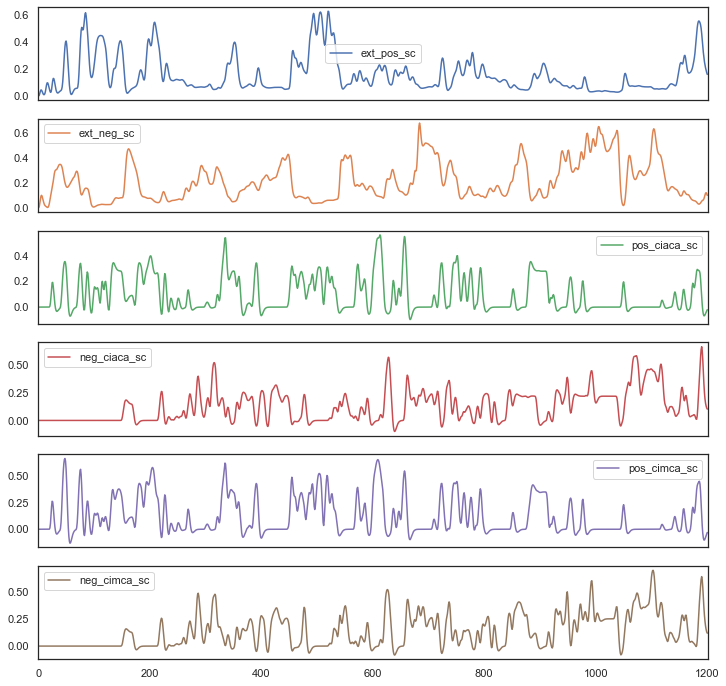

In [29]:
hrf_data = pd.DataFrame()

hrf_tr = hrf(1, len(data))
for a in data.columns:
    hrf_data.loc[:,a] = np.convolve(data[a], hrf_tr)[:len(data)]
    
hrf_data.plot(figsize=(12,12), subplots=True, xlim=(0, len(data)))

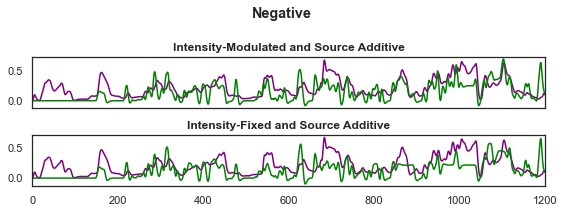

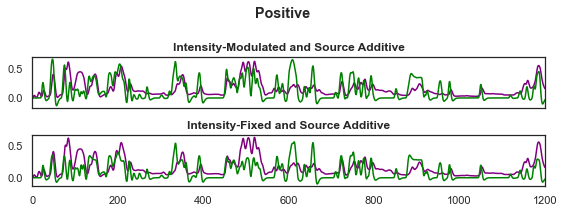

In [30]:
# plot negative
fig, ax = plt.subplots(2,1, figsize=(8,3), sharex=True)
fig.suptitle('Negative', weight='bold')
plt.setp(ax, xlim=(0,len(data)))
ax[0].plot(hrf_data['ext_neg_sc'], color='purple')
ax[0].plot(hrf_data['neg_cimca_sc'], color='green')
ax[0].set_title('Intensity-Modulated and Source Additive', weight='bold')
ax[1].plot(hrf_data['ext_neg_sc'], color='purple')
ax[1].plot(hrf_data['neg_ciaca_sc'], color='green')
ax[1].set_title('Intensity-Fixed and Source Additive', weight='bold')
plt.tight_layout()
plt.savefig(out_dir + 'internal-external_overlays_negative.svg')
plt.show()
plt.close()

# plot positive
fig, ax = plt.subplots(2,1, figsize=(8,3), sharex=True)
fig.suptitle('Positive', weight='bold')
plt.setp(ax, xlim=(0,len(data)))
ax[0].plot(hrf_data['ext_pos_sc'], color='purple')
ax[0].plot(hrf_data['pos_cimca_sc'], color='green')
ax[0].set_title('Intensity-Modulated and Source Additive', weight='bold')
ax[1].plot(hrf_data['ext_pos_sc'], color='purple')
ax[1].plot(hrf_data['pos_ciaca_sc'], color='green')
ax[1].set_title('Intensity-Fixed and Source Additive', weight='bold')
plt.tight_layout()
plt.savefig(out_dir + 'internal-external_overlays_positive.svg')
plt.show()
plt.close()

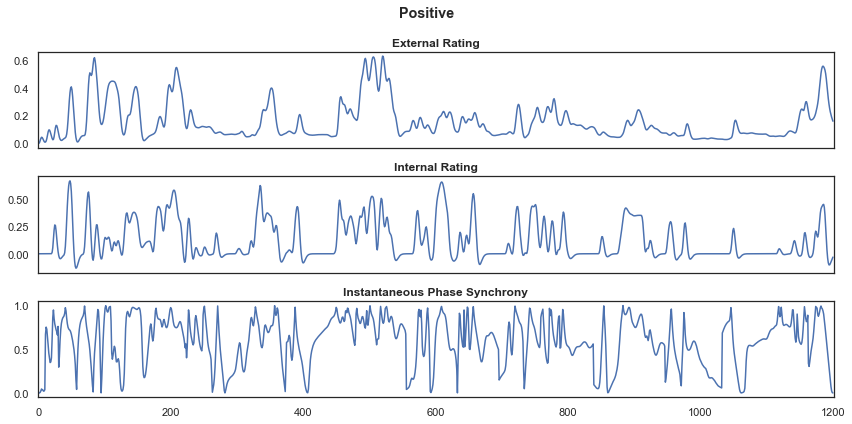

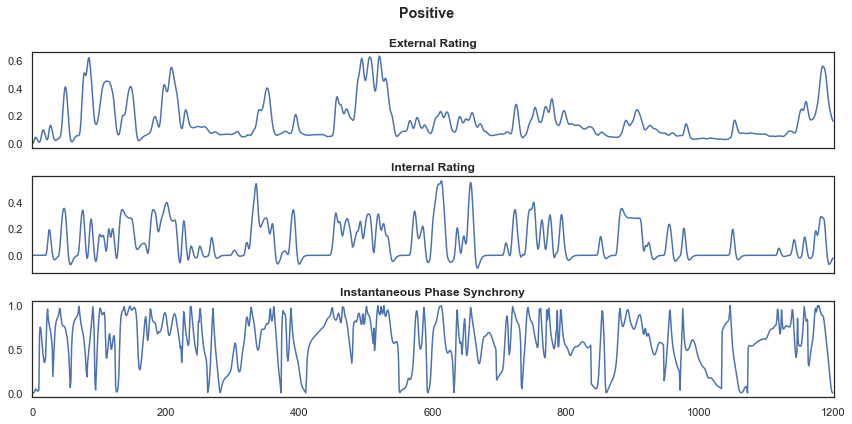

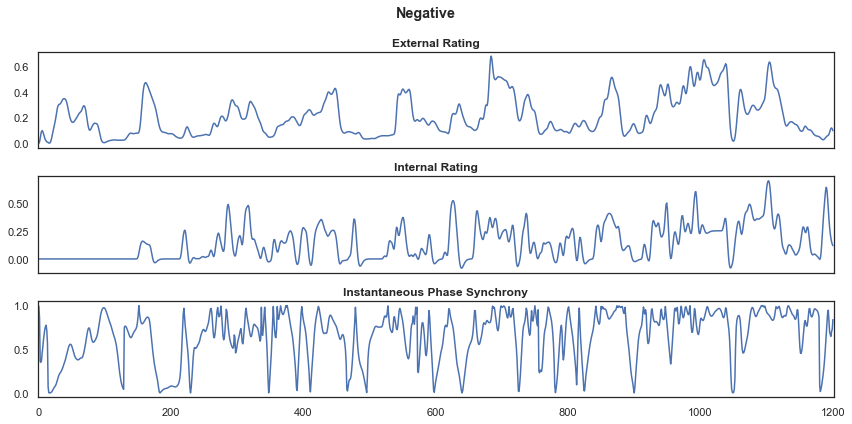

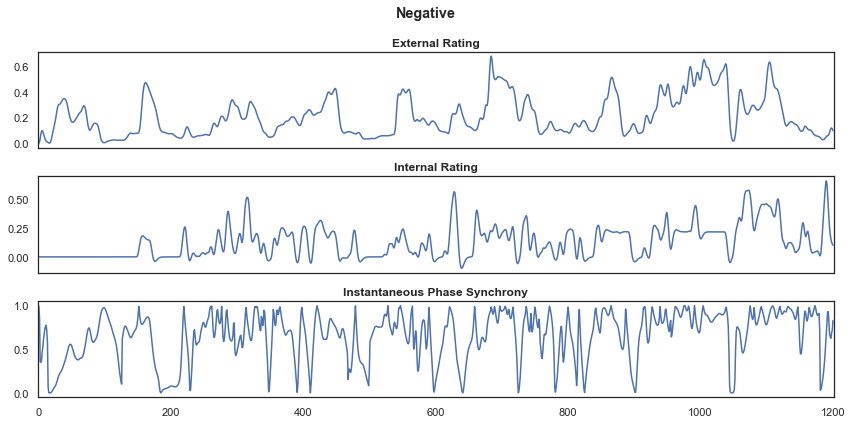

In [31]:
from scipy.signal import hilbert
from scipy.stats import spearmanr

# computer instantaneous phase synchrony
ips = pd.DataFrame(columns=['extpossc_meanIPS', 'extnegsc_meanIPS'])

for a in ['pos_cimca_sc','pos_ciaca_sc']:
    aphase = np.angle(hilbert(hrf_data['ext_pos_sc']),deg=False)
    bphase = np.angle(hilbert(hrf_data[a]),deg=False)
    phase_synchrony = 1-np.sin(np.abs(aphase-bphase)/2)
    ips.loc[a,'extpossc_meanIPS'] = np.mean(phase_synchrony)
    fig, ax = plt.subplots(3,1, figsize=(12,6), sharex=True)
    fig.suptitle('Positive', weight='bold')
    plt.setp(ax, xlim=(0,len(data)))
    ax[0].plot(hrf_data['ext_pos_sc'])
    ax[0].set_title('External Rating', weight='bold')
    ax[1].plot(hrf_data[a])
    ax[1].set_title('Internal Rating', weight='bold')
    ax[2].plot(phase_synchrony)
    ax[2].set_title('Instantaneous Phase Synchrony', weight='bold')
    plt.tight_layout()
    plt.savefig(out_dir + 'IPS_Negative_ext_{0}.svg'.format(a))
    plt.show()

for a in ['neg_cimca_sc','neg_ciaca_sc']:
    aphase = np.angle(hilbert(hrf_data['ext_neg_sc']),deg=False)
    bphase = np.angle(hilbert(hrf_data[a]),deg=False)
    phase_synchrony = 1-np.sin(np.abs(aphase-bphase)/2)
    ips.loc[a,'extnegsc_meanIPS'] = np.mean(phase_synchrony)
    fig, ax = plt.subplots(3,1, figsize=(12,6), sharex=True)
    fig.suptitle('Negative', weight='bold')
    plt.setp(ax, xlim=(0,len(data)))
    ax[0].plot(hrf_data['ext_neg_sc'])
    ax[0].set_title('External Rating', weight='bold')
    ax[1].plot(hrf_data[a])
    ax[1].set_title('Internal Rating', weight='bold')
    ax[2].plot(phase_synchrony)
    ax[2].set_title('Instantaneous Phase Synchrony', weight='bold')
    plt.tight_layout()
    plt.savefig(out_dir + 'IPS_Negative_ext_{0}.svg'.format(a))
    plt.show()
    
ips.to_csv(out_dir + 'IPS_int_ext.csv')

# compute correlation coefficient
corrspear = pd.DataFrame(columns=['ext_pos_sc', 'ext_neg_sc'])

for a in ['pos_cimca_sc','pos_ciaca_sc']:
    r, p = spearmanr(hrf_data['ext_pos_sc'], hrf_data[a])
    corrspear.loc[a, 'ext_pos_sc'] = r
    
for a in ['neg_cimca_sc','neg_ciaca_sc']:
    r, p = spearmanr(hrf_data['ext_neg_sc'], hrf_data[a])
    corrspear.loc[a, 'ext_neg_sc'] = r   
    
corrspear.to_csv(out_dir + 'spearman_corr_int_ext.csv')